In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.corpus import stopwords
from nltk.util import ngrams 
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter 
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import re 
from nltk.tokenize import word_tokenize
import gensim 
import string 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant 
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-02-10 15:53:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-10 15:53:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-10 15:53:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [4]:
tweet = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],
                                                         tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],
                                                         test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


# Class Distribution 
Before we begin with anything else, let's check the class distribution. There are only two classes 0 & 1.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


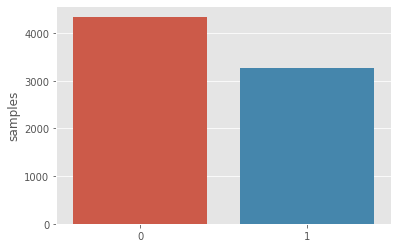

In [7]:
x = tweet.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')
plt.show()

- There is a class distribution. THere are more tweets with class 0(No Disaster) than class 1 (Disaster tweet)

BASIC EDA 
- character level 
- word level 
- sentence level analysis 

## Number of characters in tweets

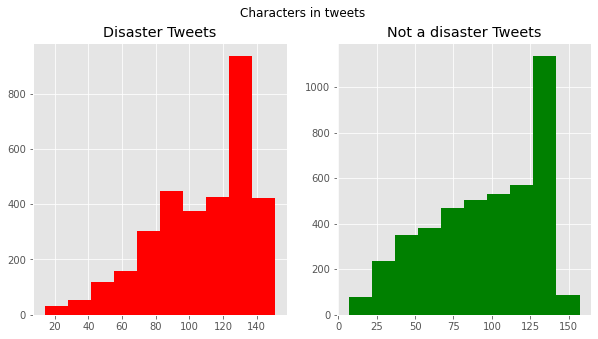

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len = tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='red')
ax1.set_title('Disaster Tweets')
tweet_len = tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='green')
ax2.set_title('Not a disaster Tweets')
fig.suptitle('Characters in tweets')
plt.show()

## Number of words in a tweet 

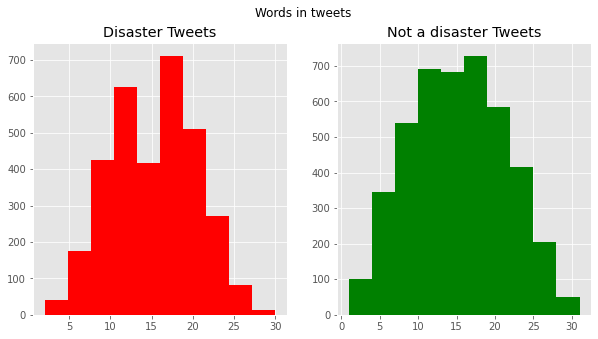

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len = tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='red')
ax1.set_title('Disaster Tweets')
tweet_len = tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='green')
ax2.set_title('Not a disaster Tweets')
fig.suptitle('Words in tweets')
plt.show()

## Average Word Length in a tweet

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


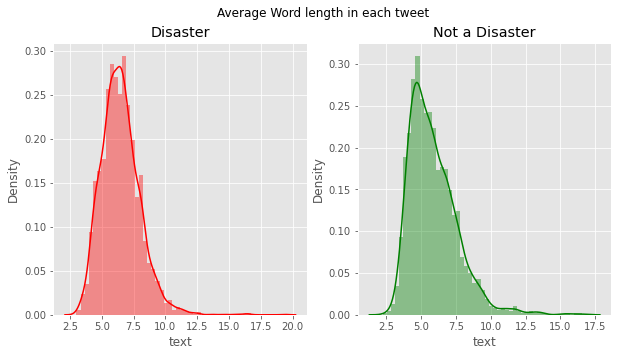

In [17]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
word = tweet[tweet['target'] == 1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x : np.mean(x)), ax=ax1, color='red')
ax1.set_title("Disaster")
word = tweet[tweet['target'] ==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x:np.mean(x)), ax=ax2, color='green')
ax2.set_title("Not a Disaster")
fig.suptitle('Average Word length in each tweet')
plt.show()

In [19]:
# Creating Corpus

def create_corpus(target):
    corpus = []

    for x in tweet[tweet['target'] == target]['text'].str.split():
        for i in x: 
            corpus.append(i)
    return corpus

In [25]:
# COMMON STOPWORDS IN TWEETS


# First we will analyze tweets with class 0 

corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus: 
    if word in stop: 
        dic[word]+=1


top = sorted(dic.items(), key = lambda x : x[1], reverse=True)[:10]

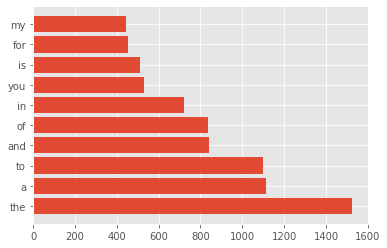

In [26]:
x, y = zip(*top)
plt.barh(x, y)
plt.show()

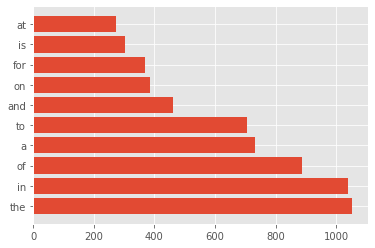

In [27]:
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus: 
    if word in stop: 
        dic[word]+=1


top = sorted(dic.items(), key = lambda x : x[1], reverse=True)[:10]

x, y = zip(*top)
plt.barh(x, y)
plt.show()

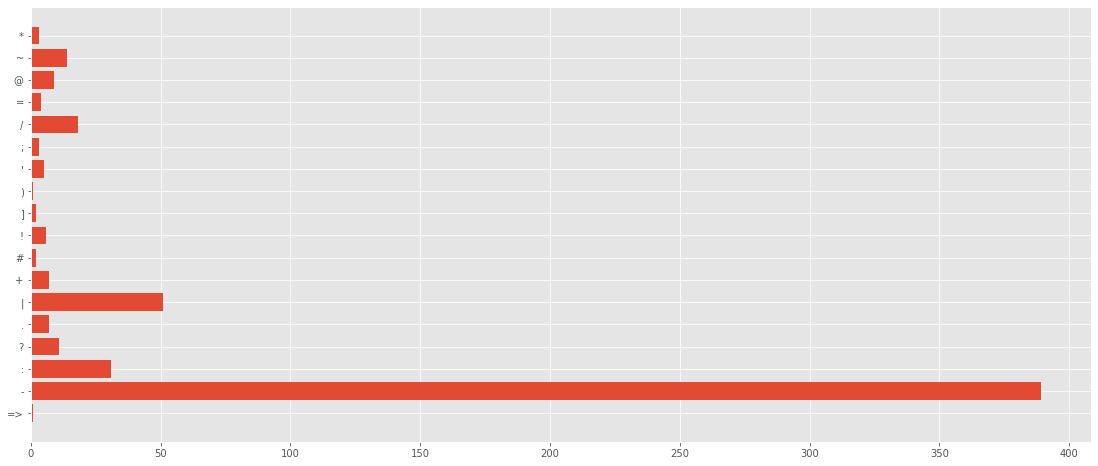

In [29]:
# Analyzing Punctuations 

# first let's check tweets indicating real disaster

plt.figure(figsize=(19, 8))
corpus = create_corpus(1)

dic = defaultdict(int)

import string 
special = string.punctuation

for i in (corpus):
    if i in special:
        dic[i] +=1


x, y = zip(*dic.items())
plt.barh(x, y)
plt.show()

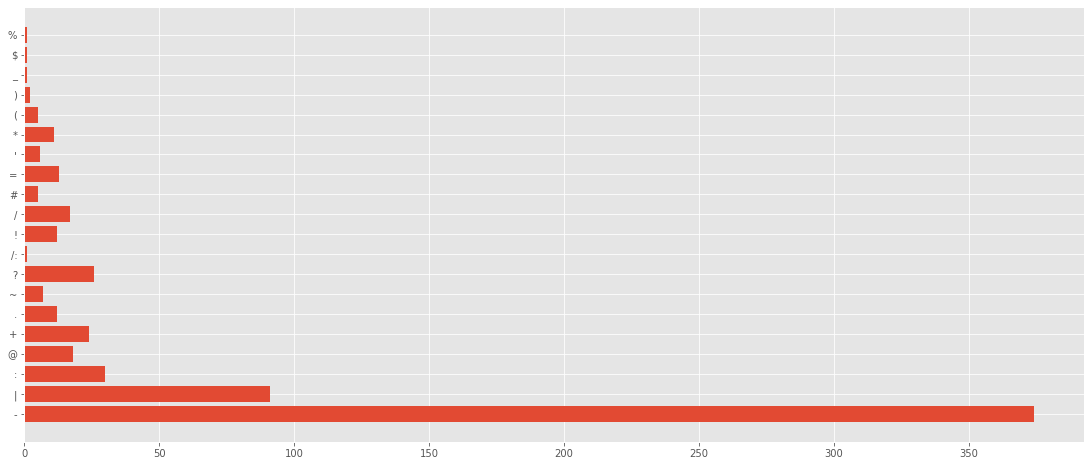

In [30]:
# with class 0 

plt.figure(figsize=(19, 8))
corpus = create_corpus(0)

dic = defaultdict(int)

import string 
special = string.punctuation

for i in (corpus):
    if i in special:
        dic[i] +=1


x, y = zip(*dic.items())
plt.barh(x, y)
plt.show()

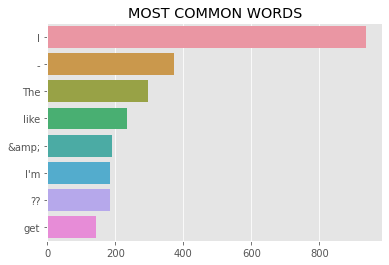

In [32]:
# COmmon words investigation which are also not part of stop words 
# DAYA DARWAJAA TODO !!!!!!!

counter = Counter(corpus)
most = counter.most_common()

x = []
y = []

for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y, y=x)
plt.title('MOST COMMON WORDS')
plt.show()

In [35]:
# Ngram analysis 


# we will do a bigram (n=2) analysis over the tweets. Let's check the most common bigrams in tweets


def get_top_tweet_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq = sorted(words_freq, key = lambda x : x[1], reverse=True)

    return words_freq[:n]

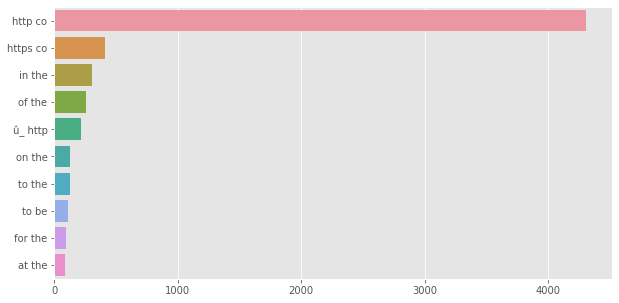

In [36]:
plt.figure(figsize=(10, 5))
top_tweet_bigrams = get_top_tweet_bigram(tweet['text'])[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)
plt.show()

In [37]:
# DATA CLEANING

# we know twitter  tweets always need to be cleaned before we go onto modeling 
# so we will do some basic cleaning such as 
# 1 Spell correction 
# 2 Removing punctuations 
# 3 Removing html tags 
# 4 emojis 
# etc so let's start 


df = pd.concat([tweet, test])

df.shape

(10876, 5)

In [38]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [40]:
ex = "# we know twitter  tweets always need to be cleaned before we go onto modeling https://colab.research.google.com/drive"
remove_url(ex)

'# we know twitter  tweets always need to be cleaned before we go onto modeling '

In [41]:
df['text'] = df['text'].apply(lambda x : remove_url(x))

In [44]:
# Removing HTML tags 

example = """
<div>
<h1>hey this is the fake html</h1>
</div>
"""

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

print(remove_html(example))



hey this is the fake html




In [45]:
df['text'] = df['text'].apply(lambda x : remove_html(x))

In [48]:
#Removing Emojis 

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Shit not a great batting from Indian side, England won the first test in chennai 😔😔")

'Shit not a great batting from Indian side, England won the first test in chennai '

In [49]:
df['text'] = df['text'].apply(lambda x : remove_emoji(x))

In [50]:
# Removing Punctuations 

def remove_punctuate(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

print(remove_punctuate('Wow!! thats really great. but what is the time?'))

Wow thats really great but what is the time


In [51]:
df['text'] = df['text'].apply(lambda x : remove_punctuate(x))

In [52]:
# spell correction 

!pip install pyspellchecker

     |████████████████████████████████| 2.5MB 7.5MB/s 


In [54]:
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words : 
            corrected_text.append(spell.correction(word))
        else : 
            corrected_text.append(word)
        
    return " ".join(corrected_text)
text = "gooud jub"
correct_spellings(text)

'good job'